In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline
import numpy as np
import pandas as pd
from numpy.linalg import norm
import scipy as sp
from scipy.io import loadmat
#from sympy import *

In [2]:
image = loadmat('train.mat')['X'].T
y = loadmat('train.mat')['y']

In [30]:
imagetest = loadmat('test.mat')['X'].T

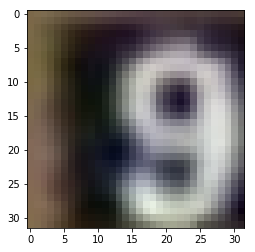

In [36]:
plt.imshow(imagetest[43].T)

In [ ]:
image[:, :, :,1].shape

In [4]:
def display_stats(X,y,sample_id):
    features, labels = X,y

    if not (0 <= sample_id < len(features)):
        print('{} samples {}.  {} is out of range.'.format(len(features), sample_id))
        return None

    sample_image = features[sample_id].T
    sample_label = labels[sample_id]

    print('Example of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} '.format(sample_label))
    plt.axis('off')
    plt.imshow(sample_image)

Example of Image 200:
Image - Min Value: 45 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: [5] 


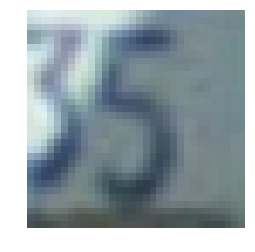

In [6]:
display_stats(image, y, 200)

In [10]:
# Normalize data
Xtrain=image/255
Xtest=image/255

In [11]:
Xtrain.shape

(73257, 3, 32, 32)

In [7]:
np.min(y)

1

In [8]:
from keras.utils import to_categorical
y_oh= to_categorical(y, num_classes=None)
y_oh = np.delete(y_oh, 0, axis=1)

In [ ]:
y_oh [52]

In [12]:
k= np.zeros(shape=(73257, 32, 32, 3))
for i, j in enumerate(Xtrain):
    k[i]=j.T

In [13]:
Xtrain=k
Xtrain.shape

(73257, 32, 32, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, y_oh, test_size=0.2, random_state=42)

In [7]:
y_valid.shape

(14652, 10)

In [5]:
X_train=np.float16(X_train)
X_valid=np.float16(X_valid)
y_train=np.uint8(y_train)
y_valid=np.uint8(y_valid)

In [6]:
X_train.dtype

dtype('float16')

In [30]:
data={'X_train': X_train, 'X_valid':X_valid, 'y_train':y_train,'y_valid':y_valid}

In [21]:
# Save data in file
np.savez("data.npz",  X_train= X_train, X_valid=X_valid, y_train=y_train,y_valid=y_valid)

In [2]:
# Read from file
npzfile = np.load("data.npz")
npzfile.files

['X_valid', 'y_valid', 'X_train', 'y_train']

In [3]:
X_train=npzfile['X_train']
y_train=npzfile['y_train']
X_valid=npzfile['X_valid']
y_valid=npzfile['y_valid']

In [4]:
X=np.concatenate((X_train, X_valid), axis=0)
y=np.concatenate((y_train, y_valid), axis=0)

In [9]:
y_valid.shape

(14652, 10)

In [10]:
X_train.shape

(58605, 32, 32, 3)

In [6]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [3]:
print(keras.__version__)

2.1.5


In [7]:
batch_size = 512
epochs = 30
num_classes = 10
kernel_size=5

In [8]:
from keras.layers import Lambda
import keras.backend as K

def l2_s(x):
    x = x ** 2
    return x

def l2_r(x,f):
    x = K.sqrt(x*(f**2))
    return x

def l2pooling(filters, strides):
    model.add(Lambda(lambda x: l2_s(x)))
    model.add(AveragePooling2D(pool_size=(filters, filters), strides=(strides, strides)))
    model.add(Lambda(lambda x: l2_r(x,filters)))
    return model

In [35]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),strides=(1, 1), input_shape=(32,32,3),padding='same'))
l2pooling(3, 2)
model.add(Activation('relu'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu',padding='same'))
l2pooling(3, 2)
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu',padding='same'))       
l2pooling(3, 2)
model.add(BatchNormalization(axis=1))   

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [36]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model_train = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, y_valid))

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73257/73257 [==============================] - 14s 186us/step - loss: 2.2547 - acc: 0.1847 - val_loss: 2.1964 - val_acc: 0.2007

In [38]:
model.evaluate(X_valid, y_valid, batch_size=32, verbose=1, sample_weight=None)

26032/26032 [==============================] - 4s 171us/step

[0.21614621588605393, 0.9411493546404426]

In [50]:
# Save the model as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
# model reconstruction from JSON:
from keras.models import model_from_json
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

NameError: name 'l2_s' is not defined

In [52]:
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
imagetest = loadmat('test.mat')['X'].T
X_test=imagetest/255

In [14]:
X_test.shape

(26032, 3, 32, 32)

In [15]:
k= np.zeros(shape=(26032, 32, 32, 3))
for i, j in enumerate(X_test):
    k[i]=j.T

In [16]:
X_test=k
X_test.shape

(26032, 32, 32, 3)

In [17]:
testPredict = model.predict(X_test).argmax(axis=-1)+1

In [18]:
testPredict.shape

(26032,)

In [19]:
testPredict=pd.DataFrame(testPredict)

In [20]:
testPredict.head(3)

,0
0,5
1,2
2,1


In [21]:
testPredict.to_csv('prediction5.csv', index=True)